In [842]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import math

In [924]:
def h(x):
    r = np.sqrt((x[0]+75)**2+(x[1]+50)**2)
    theta = np.arctan2(x[1]+50,x[0]+75)
    return np.array([r,theta]).transpose()

In [925]:
def dr_dx(data):
    x = data[0] +75 
    y = data[1] +50
    return x/np.sqrt(x**2+y**2)

In [926]:
def dr_dy(data):
    x = data[0] + 75
    y = data[1] + 50
    return y/np.sqrt(x**2+y**2)

In [927]:
def dtheta_dx(data):
    x = data[0] + 75
    y = data[1] +50
    return -y/(x**2+y**2)

In [928]:
def dtheta_dy(data):
    x = data[0] + 75
    y = data[1] + 50
    return x/(x**2+y**2)

In [929]:
def ek(x,z,R):
    hx = h(x)
    res = (hx-z)@(np.linalg.inv(R))@(hx-z).transpose()
    #print(res)
    return res

In [930]:
def J(x):
    res = np.zeros((2,2))
    res[0,0] = dr_dx(x)
    res[0,1] = dr_dy(x)
    res[1,0] = dtheta_dx(x)
    res[1,1] = dtheta_dy(x)      
    return res

In [931]:
def F(X,Z,R):
    e_1k = [ek(X[i,:],Z[i,:],R) for i in range(X.shape[0])]
    F_sum = np.sum(e_1k)
    return F_sum
def F2(X, Z1, Z2, R1, R2):
    x_hat = X
    z_hat_k = h(x_hat)
    z_k1 = Z1
    z_k2 = Z2
    e_k1  = z_hat_k - z_k1
    e_k2 = z_hat_k - z_k2
    angle = e_k1[1]
    e_k1[1] = (angle + math.pi) % (2 * math.pi) - math.pi
    angle = e_k2[1]
    e_k2[1] = (angle + math.pi) % (2 * math.pi) - math.pi
    return (0.5*e_k1.transpose()@R1@e_k1) + (0.5*e_k2.transpose()@R2@e_k2)

In [932]:
def get_xy(r,theta):
    x = r*np.cos(theta) -75
    y = r*np.sin(theta) -50
    return np.array([x, y])

In [1021]:
def GaussNewtwonMinimization(X_init,Z1,Z2,R1,R2):
    F_new = (F(X_init,Z1,R1)+F(X_init,Z2,R2))/2
    print(F_new)
    F_hat = F_new
    X_hat = X_init.copy()
    K = Z1.shape[0]
    R1_inv = np.linalg.inv(R1)
    R2_inv = np.linalg.inv(R2)
    F2(X_init[0,:], Z1[0,:], Z2[0,:], R1_inv, R2_inv)
    max_itr = 0
    count = 0
    alpha = 0.5
    beta = 0.5
    eps = 1e-8
    while(True):
        F_hat = F_new
        b = np.zeros(2*K)
        H = np.zeros((2*K,2*K))
        for k in range(K):
            x_hat = X_hat[k,:]
            z_hat_k = h(x_hat)
            z_k1 = Z1[k,:]
            z_k2 = Z2[k,:]
            e_k1  = z_hat_k - z_k1
            e_k2 = z_hat_k-z_k2
            angle = e_k1[1]
            e_k1[1] = (angle + math.pi) % (2 * math.pi) - math.pi
            angle = e_k2[1]
            e_k2[1] = (angle + math.pi) % (2 * math.pi) - math.pi
            if(count == max_itr -1 ):
                pass
                #print(z_hat_k, z_k1,x_hat)
            J_k = J(x_hat)
            H_k = (J_k.transpose()@(R1_inv)@J_k)+(J_k.transpose()@(R2_inv)@J_k)
            b_k = (J_k.transpose()@R1_inv@e_k1)+(J_k.transpose()@R2_inv@e_k2)
            
            delta_X_k =  np.linalg.pinv(H_k)@b_k
            itr = 0
            alpha = 0.5
            beta = 0.99
            t= 0.01
            while((np.linalg.norm(b_k)) > eps) and (itr < 10):
                t=1
                itr+=1
               # print(x_hat - t*delta_X_k)
                while F2(x_hat - t*delta_X_k, Z1[k,:], Z2[k,:], R1_inv, R2_inv) > F2(x_hat, Z1[k,:], Z2[k,:], R1_inv, R2_inv)-alpha*t*b_k.transpose()@delta_X_k :
                    t = beta*t
                print("got t: ",t)
                print("norm grad: ", np.linalg.norm(b_k))
                print(f"cost for point {k} before iter: {itr} : {F2(x_hat, Z1[k,:], Z2[k,:], R1_inv, R2_inv)}")
                x_hat = x_hat - t*delta_X_k
                #t = 0.5*t
                print(f"cost for point {k}, iter: {itr} : {F2(x_hat, Z1[k,:], Z2[k,:], R1_inv, R2_inv)}")
                z_hat_k = h(x_hat)
                z_k1 = Z1[k,:]
                z_k2 = Z2[k,:]
                e_k1  = z_hat_k - z_k1
                e_k2 = z_hat_k-z_k2
                angle = e_k1[1]
                e_k1[1] = (angle + math.pi) % (2 * math.pi) - math.pi
                angle = e_k2[1]
                e_k2[1] = (angle + math.pi) % (2 * math.pi) - math.pi
                J_k = J(x_hat)
                H_k = (J_k.transpose()@(R1_inv)@J_k)+(J_k.transpose()@(R2_inv)@J_k)
                print("printing Hk: ", H_k)
                b_k = (J_k.transpose()@R1_inv@e_k1)+(J_k.transpose()@R2_inv@e_k2)
                delta_X_k = np.linalg.pinv(H_k)@b_k
            #delta_X_k = -0.01*b_k
            #x_hat += delta_X_k
            X_hat[k,:] = x_hat
            itr = itr + 1
          #  print("cost: ",  F2(X_hat[k,:], Z1[k,:], Z2[k,:], R1_inv, R2_inv))
            #dH[2*k:2*(k+1),2*k:2*(k+1)]=H_k
            #b[2*k:2*(k+1)]=b_k
        #print(H,b)
        #delta_X =  np.linalg.pinv(H)@b
        #print(delta_X.max(),delta_X.min())
        #delta_X = delta_X.reshape((-1,2))
        #print(H,b,delta_X)
        #X_hat += delta_X
        F_new = (F(X_hat,Z1,R1)+F(X_hat,Z2,R2))/2
        #print(F_new,(F_hat-F_new))
        #print(H)
        count +=1
        #if np.abs(F_hat-F_new)<5:
        if count>max_itr:
            break
    return X_hat,F_new

In [1022]:
data1 = pd.read_csv('./gauss_noise1_rt.csv')
data2 = pd.read_csv('./gauss_noise2_rt.csv')
gt_data = pd.read_csv('./ground_truth.csv')
data1 = data1.to_numpy()
data2 = data2.to_numpy()
gt_data = gt_data.to_numpy()

In [1023]:
Z1 = data1[:,2:4]
Z2 = data2[:,2:4]
X_init1 = get_xy(Z1[:,0], Z1[:,1])
X_init2 = get_xy(Z2[:,0], Z2[:,1])
#print(X1_init)
#X1_init = (X_init1 + X_init2)/2.0

X1_init = (X_init1.transpose()*0.5+X_init2.transpose()*0.5)
#X1_init = (X_init2.transpose())
print(X1_init)
#X1_init = np.random.rand(Z1.shape[0],2)
R1=np.diag([0.01,0.04])
R2=np.diag([16,0.0004])
print(Z1.shape,X1_init.shape,R1.shape)

[[ 6.54314776e+00 -1.34410860e+01]
 [ 9.19517970e-01  3.21583913e+00]
 [ 5.37646505e+00 -1.56809649e+01]
 [-5.08648914e+00  7.88900344e+00]
 [ 3.00587807e+00 -3.04350132e+00]
 [ 3.88947732e+00 -9.14951594e+00]
 [-1.30059106e+00  4.18679578e+00]
 [ 8.74727371e-01  9.38787485e-01]
 [ 2.57283863e+00 -8.59461120e-01]
 [-5.41859611e+00  7.44929537e+00]
 [-1.45775594e+00  7.33292868e+00]
 [-2.40303911e+00 -8.92680241e-02]
 [-1.39421497e+00 -2.67450331e+00]
 [ 3.66114833e+00  4.16945624e+00]
 [ 3.73965025e+00 -8.89037006e+00]
 [-2.09126389e+00  7.05948430e+00]
 [-9.05608885e+00  1.20049125e+01]
 [ 3.41221084e+00 -3.52533043e+00]
 [-3.18240346e+00  6.27665512e+00]
 [-2.77979758e+00  2.61369583e+00]
 [-1.35660502e+01  1.65024398e+01]
 [ 3.73476373e+00 -1.12978283e+01]
 [ 5.78679115e-01 -1.34215308e+00]
 [-3.33911170e+00  2.56814620e+00]
 [-8.28905844e-01  1.57039163e+00]
 [-1.05695104e+01  1.28017520e+01]
 [ 7.02458607e+00 -1.62609855e+01]
 [-8.70540698e+00  1.10389462e+01]
 [ 2.24104288e-01 -3

In [1008]:
print(1/R1,np.linalg.inv(R2))

[[100.  inf]
 [ inf  25.]] [[6.25e-02 0.00e+00]
 [0.00e+00 2.50e+03]]


/home/sai/.conda/envs/domainrand/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [1024]:
X1_hat,F_new = GaussNewtwonMinimization(X1_init,Z1,Z2,R1,R2)

205272.36217276825
got t:  0.8179069375972307
norm grad:  91.8897095083914
cost for point 0 before iter: 1 : 70.13376425741717
cost for point 0, iter: 1 : 12.822123344287318
printing Hk:  [[73.74876741 43.96062478]
 [43.96062478 26.62037148]]
got t:  0.99
norm grad:  46.32607854466757
cost for point 0 before iter: 2 : 12.822123344287318
cost for point 0, iter: 2 : 1.1820134799338204
printing Hk:  [[71.25316836 45.20883959]
 [45.20883959 29.11884874]]
got t:  0.99
norm grad:  4.002912475206618
cost for point 0 before iter: 3 : 1.1820134799338204
cost for point 0, iter: 3 : 1.101927725223474
printing Hk:  [[71.24005617 45.21486094]
 [45.21486094 29.13223253]]
got t:  1
norm grad:  0.04012524143047271
cost for point 0 before iter: 4 : 1.101927725223474
cost for point 0, iter: 4 : 1.101919677578438
printing Hk:  [[71.23992956 45.21491902]
 [45.21491902 29.13236189]]
got t:  0.99
norm grad:  251.93043825456618
cost for point 1 before iter: 1 : 320.59829270857153
cost for point 1, iter: 1 : 

got t:  0.8345137614500874
norm grad:  89.67526045336277
cost for point 43 before iter: 1 : 65.39980879933499
cost for point 43, iter: 1 : 11.020865291796568
printing Hk:  [[75.36977443 43.04830807]
 [43.04830807 25.01380508]]
got t:  0.99
norm grad:  43.088442765560856
cost for point 43 before iter: 2 : 11.020865291796568
cost for point 43, iter: 2 : 1.0379119412586124
printing Hk:  [[73.2484971  44.21987967]
 [44.21987967 27.13799988]]
got t:  0.99
norm grad:  3.041189581717469
cost for point 43 before iter: 3 : 1.0379119412586124
cost for point 43, iter: 3 : 0.9916792595722033
printing Hk:  [[73.23696396 44.22582386]
 [44.22582386 27.14975399]]
got t:  1
norm grad:  0.030487744795507043
cost for point 43 before iter: 4 : 0.9916792595722033
cost for point 43, iter: 4 : 0.9916746129042133
printing Hk:  [[73.23685145 44.22588181]
 [44.22588181 27.14986874]]
got t:  0.9801
norm grad:  104.58091519935178
cost for point 44 before iter: 1 : 58.15421372256946
cost for point 44, iter: 1 : 1.

cost for point 94, iter: 1 : 4.257191100471105
printing Hk:  [[ 93.65086261 -24.45321649]
 [-24.45321649   6.80086333]]
got t:  0.99
norm grad:  27.105041630287328
cost for point 94 before iter: 2 : 4.257191100471105
cost for point 94, iter: 2 : 0.5769227321804117
printing Hk:  [[ 93.78459416 -24.21385953]
 [-24.21385953   6.66973371]]
got t:  0.99
norm grad:  0.3013008069748925
cost for point 94 before iter: 3 : 0.5769227321804117
cost for point 94, iter: 3 : 0.5764687199184804
printing Hk:  [[ 93.78548289 -24.21225698]
 [-24.21225698   6.66887408]]
got t:  1
norm grad:  0.003014355123697399
cost for point 94 before iter: 4 : 0.5764687199184804
cost for point 94, iter: 4 : 0.5764686744724548
printing Hk:  [[ 93.78549183 -24.21224085]
 [-24.21224085   6.66886543]]
got t:  0.99
norm grad:  118.46506251156441
cost for point 95 before iter: 1 : 72.03319783989159
cost for point 95, iter: 1 : 0.30581022778586286
printing Hk:  [[ 95.93802903 -19.85186551]
 [-19.85186551   4.51168469]]
got t:

norm grad:  0.5112084937076776
cost for point 146 before iter: 3 : 0.7263739974030308
cost for point 146, iter: 3 : 0.7250669313086592
printing Hk:  [[ 46.27993152 -49.71446089]
 [-49.71446089  54.10843548]]
got t:  1
norm grad:  0.0051166905742614024
cost for point 146 before iter: 4 : 0.7250669313086592
cost for point 146, iter: 4 : 0.7250668003550744
printing Hk:  [[ 46.27996402 -49.71446325]
 [-49.71446325  54.10840336]]
got t:  0.99
norm grad:  90.46184375633067
cost for point 147 before iter: 1 : 43.369642340491254
cost for point 147, iter: 1 : 0.5984201178074126
printing Hk:  [[ 43.39684778 -49.39929466]
 [-49.39929466  56.99778236]]
got t:  0.99
norm grad:  8.736048611467707
cost for point 147 before iter: 2 : 0.5984201178074126
cost for point 147, iter: 2 : 0.21710345954048027
printing Hk:  [[ 43.39544497 -49.39872328]
 [-49.39872328  56.99984462]]
got t:  0.99
norm grad:  0.08736189672449393
cost for point 147 before iter: 3 : 0.21710345954048027
cost for point 147, iter: 3 :

got t:  0.8953382542587163
norm grad:  66.0081638735435
cost for point 196 before iter: 1 : 37.64469585391876
cost for point 196, iter: 1 : 4.406390508592725
printing Hk:  [[18.65932034 38.44367835]
 [38.44367835 81.906988  ]]
got t:  0.99
norm grad:  26.75695575902143
cost for point 196 before iter: 2 : 4.406390508592725
cost for point 196, iter: 2 : 0.6308347531658378
printing Hk:  [[19.63996529 39.22601209]
 [39.22601209 80.93005124]]
got t:  0.99
norm grad:  0.8265754521113358
cost for point 196 before iter: 3 : 0.6308347531658378
cost for point 196, iter: 3 : 0.6274130027380727
printing Hk:  [[19.64629582 39.23083632]
 [39.23083632 80.9238384 ]]
got t:  0.99
norm grad:  0.008288041282370947
cost for point 196 before iter: 4 : 0.6274130027380727
cost for point 196, iter: 4 : 0.6274126587380069
printing Hk:  [[19.64635841 39.230884  ]
 [39.230884   80.92377699]]
got t:  1
norm grad:  8.288259056851272e-05
cost for point 196 before iter: 5 : 0.6274126587380069
cost for point 196, ite

 [46.07210299 31.67696892]]
got t:  0.9702989999999999
norm grad:  51.67847498026463
cost for point 246 before iter: 1 : 18.62637328838221
cost for point 246, iter: 1 : 0.7425307019045864
printing Hk:  [[70.79431643 45.31103169]
 [45.31103169 29.91501072]]
got t:  0.99
norm grad:  10.112761720612417
cost for point 246 before iter: 2 : 0.7425307019045864
cost for point 246, iter: 2 : 0.2240131855814486
printing Hk:  [[71.0154193  45.20997644]
 [45.20997644 29.69598053]]
got t:  0.99
norm grad:  0.11964306371455993
cost for point 246 before iter: 3 : 0.2240131855814486
cost for point 246, iter: 3 : 0.22394112932463167
printing Hk:  [[71.01727674 45.20911968]
 [45.20911968 29.69414772]]
got t:  1
norm grad:  0.0011977373155164102
cost for point 246 before iter: 4 : 0.22394112932463167
cost for point 246, iter: 4 : 0.22394112210285272
printing Hk:  [[71.01729547 45.20911104]
 [45.20911104 29.69412924]]
got t:  0.9801
norm grad:  165.24105455565228
cost for point 247 before iter: 1 : 146.16

got t:  1
norm grad:  0.050454676438293045
cost for point 296 before iter: 4 : 1.4728051591735412
cost for point 296, iter: 4 : 1.4727924386785445
printing Hk:  [[ 79.460173   -40.27453001]
 [-40.27453001  21.33169608]]
got t:  0.99
norm grad:  160.72740930200456
cost for point 297 before iter: 1 : 130.19112862545114
cost for point 297, iter: 1 : 0.42255512487137037
printing Hk:  [[ 75.75784482 -42.70971922]
 [-42.70971922  25.01020644]]
got t:  0.99
norm grad:  3.4354467759802776
cost for point 297 before iter: 2 : 0.42255512487137037
cost for point 297, iter: 2 : 0.3633939377970954
printing Hk:  [[ 75.79120253 -42.68965571]
 [-42.68965571  24.97765105]]
got t:  0.99
norm grad:  0.03480546718708254
cost for point 297 before iter: 3 : 0.3633939377970954
cost for point 297, iter: 3 : 0.3633878679278372
printing Hk:  [[ 75.79151722 -42.6894661 ]
 [-42.6894661   24.97734449]]
got t:  1
norm grad:  0.0003480947930089282
cost for point 297 before iter: 4 : 0.3633878679278372
cost for point 

got t:  0.99
norm grad:  159.22009695954
cost for point 346 before iter: 1 : 127.09914781283408
cost for point 346, iter: 1 : 0.34059323163486793
printing Hk:  [[ 12.77302229 -32.77280175]
 [-32.77280175  87.75796384]]
got t:  0.99
norm grad:  1.8923415221200894
cost for point 346 before iter: 2 : 0.34059323163486793
cost for point 346, iter: 2 : 0.322688797492333
printing Hk:  [[ 12.76672461 -32.7652773 ]
 [-32.7652773   87.76450056]]
got t:  0.99
norm grad:  0.018959614037297807
cost for point 346 before iter: 3 : 0.322688797492333
cost for point 346, iter: 3 : 0.3226870002596058
printing Hk:  [[ 12.7666633  -32.76520395]
 [-32.76520395  87.76456427]]
got t:  0.99
norm grad:  0.00018959957776481373
cost for point 346 before iter: 4 : 0.3226870002596058
cost for point 346, iter: 4 : 0.3226870000798763
printing Hk:  [[ 12.76666269 -32.76520321]
 [-32.76520321  87.7645649 ]]
got t:  1
norm grad:  1.8959966555970252e-06
cost for point 346 before iter: 5 : 0.3226870000798763
cost for poin

got t:  0.99
norm grad:  322.62745141757415
cost for point 396 before iter: 1 : 523.9787140201232
cost for point 396, iter: 1 : 1.4094110031004168
printing Hk:  [[15.65282603 35.8155653 ]
 [35.8155653  84.86572624]]
got t:  0.99
norm grad:  3.4678987301888955
cost for point 396 before iter: 2 : 1.4094110031004168
cost for point 396, iter: 2 : 1.3422332912565387
printing Hk:  [[15.82219053 35.97795172]
 [35.97795172 84.69677997]]
got t:  0.99
norm grad:  0.055296480724994816
cost for point 396 before iter: 3 : 1.3422332912565387
cost for point 396, iter: 3 : 1.3422173670524917
printing Hk:  [[15.82381241 35.97949621]
 [35.97949621 84.69516481]]
got t:  1
norm grad:  0.0005548416968313701
cost for point 396 before iter: 4 : 1.3422173670524917
cost for point 396, iter: 4 : 1.3422173654496148
printing Hk:  [[15.82382878 35.9795118 ]
 [35.9795118  84.69514851]]
got t:  0.9414801494009999
norm grad:  35.9288642357119
cost for point 397 before iter: 1 : 9.659490160339352
cost for point 397, i

got t:  0.99
norm grad:  59.05416996237933
cost for point 442 before iter: 2 : 18.889350610767185
cost for point 442, iter: 2 : 1.3258571654614233
printing Hk:  [[61.73570115 48.52990526]
 [48.52990526 38.61328494]]
got t:  0.99
norm grad:  1.1225509091226384
cost for point 442 before iter: 3 : 1.3258571654614233
cost for point 442, iter: 3 : 1.3195589699465784
printing Hk:  [[61.7317474  48.53082022]
 [48.53082022 38.61730649]]
got t:  0.99
norm grad:  0.011233404903349996
cost for point 442 before iter: 4 : 1.3195589699465784
cost for point 442, iter: 4 : 1.319558339245956
printing Hk:  [[61.73170833 48.53082925]
 [48.53082925 38.61734624]]
got t:  1
norm grad:  0.00011233482096670464
cost for point 442 before iter: 5 : 1.319558339245956
cost for point 442, iter: 5 : 1.3195583391828787
printing Hk:  [[61.73170793 48.53082935]
 [48.53082935 38.61734664]]
got t:  0.6622820409839835
norm grad:  19.148798194176248
cost for point 443 before iter: 1 : 13.560892851627246
cost for point 443,

In [893]:
print(X1_hat-X1_init,X1_hat.max())

[[-4.58030823e-01  1.82654749e-01]
 [-2.61773652e-01  6.97283630e-02]
 [ 1.70833725e-01  8.08055704e-02]
 [ 5.97033551e-02  1.03995780e-02]
 [ 1.67257521e-01  5.39478162e-02]
 [ 9.55361266e-02  3.73244450e-02]
 [-1.52759387e-01  2.67039673e-02]
 [-2.60036331e-01  5.64604050e-02]
 [-2.80653164e-02  9.16354334e-03]
 [-1.01839291e-01  1.42551647e-02]
 [-1.85196352e-01  3.87130774e-02]
 [-2.22342447e-01  3.44611026e-02]
 [ 1.93516713e-01  8.44129385e-02]
 [ 1.23391719e-01  2.40674042e-02]
 [ 9.70467997e-02  1.27721645e-02]
 [-1.31983579e-01  1.21772019e-02]
 [ 1.18956068e-01  2.71810227e-02]
 [-4.23728501e-02 -4.01379359e-03]
 [-3.75438804e-01  1.23909077e-01]
 [-4.64786133e-01  1.77492366e-01]
 [ 2.08982463e-01  9.54645462e-02]
 [ 5.82495866e-02  6.13973992e-03]
 [-2.88160861e-01  6.32661080e-02]
 [-1.67263623e-02  6.23760296e-03]
 [ 2.31805324e-02  1.02861598e-02]
 [-1.72706660e-01  1.39346012e-02]
 [ 1.40145861e-01  2.67193459e-02]
 [ 2.70308926e-02 -6.61671496e-03]
 [-1.71899137e-02  1

In [1025]:
gt_x = gt_data[:,2]
gt_y = gt_data[:,3]
x1,y1 = X1_init[:,0],X1_init[:,1]
xe,ye = X1_hat[:,0],X1_hat[:,1]
xs1, ys1 = get_xy(Z1[:,0], Z1[:,1])
xs2, ys2 = get_xy(Z2[:,0], Z2[:,1])
nl_ekf = np.load("nlekf.npz")
nl_arr = nl_ekf['arr_0']

<IPython.core.display.Javascript object>


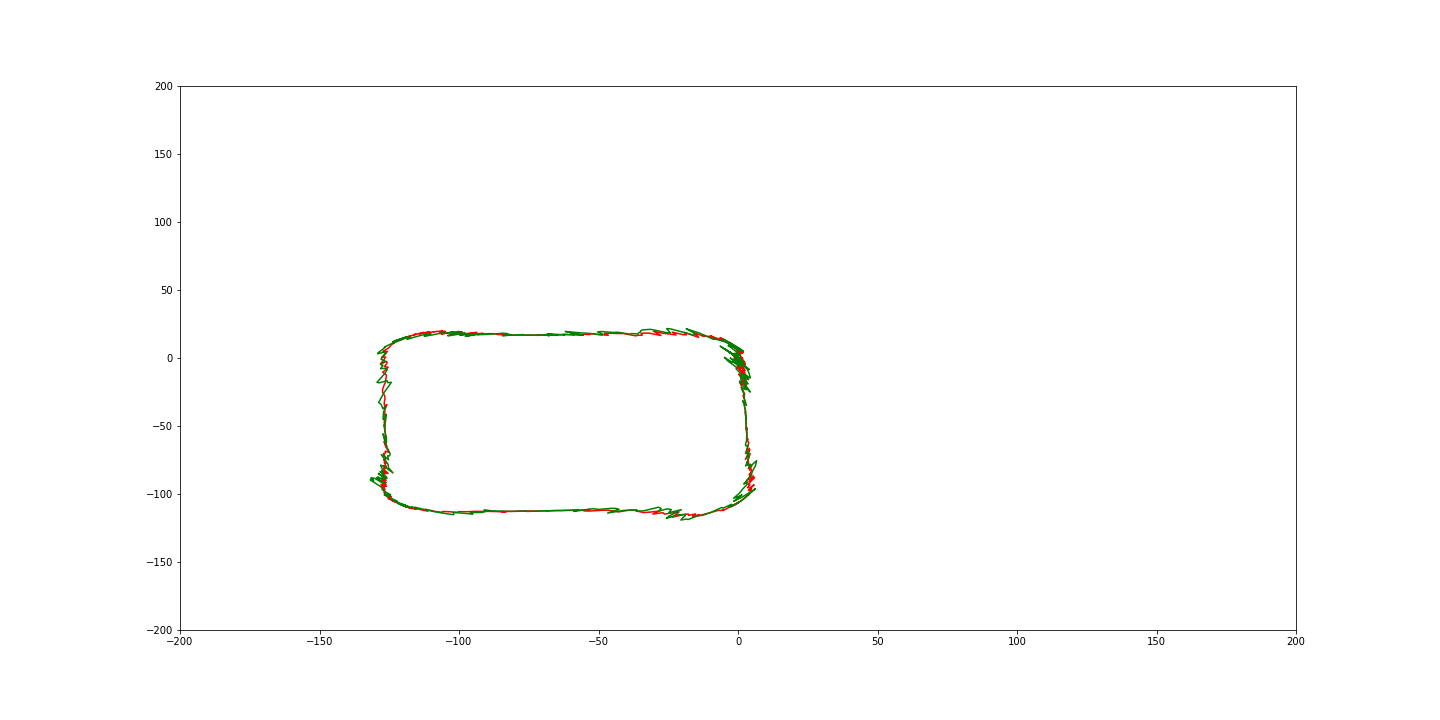

(-200, 200)

In [1028]:
fig = plt.figure(figsize=(20,10))
#plt.plot(gt_x,gt_y, "+g")
plt.plot(xe,ye, "-r")
plt.plot(nl_arr[:,0], nl_arr[:,1], '-g')
#plt.plot(xs1,ys1, "-b")
#plt.plot(xs2,ys2, "+r")
plt.xlim([-200,200])
plt.ylim([-200,200])
#print(gt_x)
#print(gt_y)
#print(xs1, ys1)

<IPython.core.display.Javascript object>


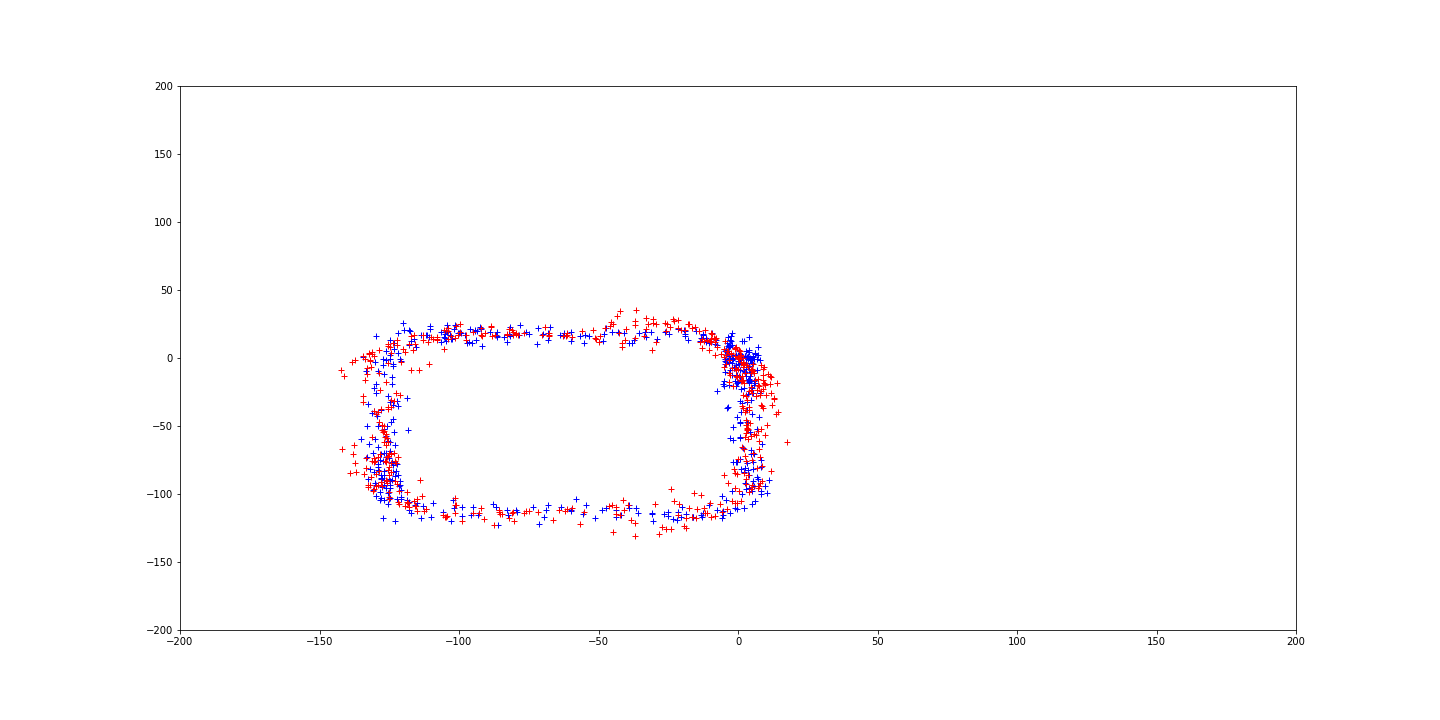

In [1031]:
fig = plt.figure(figsize=(20,10))
plt.plot(xs2,ys2, "+b")
plt.plot(xs1,ys1, "+r")
plt.xlim([-200,200])
plt.ylim([-200,200])
plt.show()

<IPython.core.display.Javascript object>


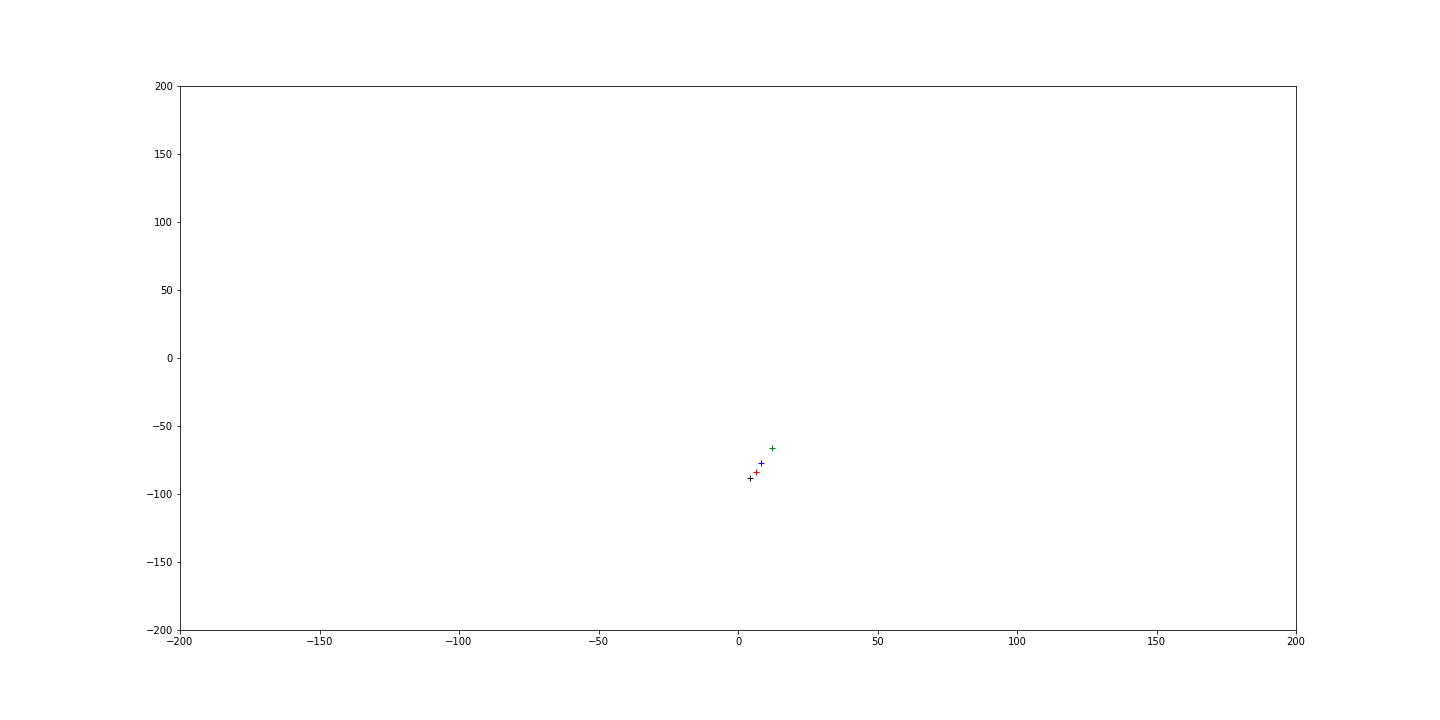

In [941]:

fig = plt.figure(figsize=(20,10))
init = 13
final = 14
plt.plot(X1_init[init:final,0], X1_init[init:final,1], "+b")
plt.plot(xe[init:final],ye[init:final], "+r")
plt.plot(xs1[init:final],ys1[init:final], "+g")
plt.plot(xs2[init:final],ys2[init:final], "+k")
plt.xlim([-200,200])
plt.ylim([-200,200])
plt.show()